In [35]:
import plotly
import seaborn as sns
# from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

%matplotlib inline

#todo: 
csv for each cuisine, 
graphing in this enviro, (run other pyplot examples, see if they work, what do they import?)
logistic regession, 
taking spaces out of middle (replace with underscore)
display notebook on webpage (git hub link)

In [36]:
import pandas as pd
import os
import numpy as np

In [37]:
#load clean CSVs 
train_clean_df = pd.read_csv('train_clean_data.csv')
train_clean_df.head()

,id,cuisine,text,category_id
0,10259,greek,"romaine_lettuce,black_olives,grape_tomatoes,ga...",0
1,25693,southern_us,"plain_flour,ground_pepper,salt,tomatoes,ground...",1
2,22213,indian,"water,vegetable_oil,wheat,salt",2
3,13162,indian,"black_pepper,shallots,cornflour,cayenne_pepper...",2
4,42779,spanish,"olive_oil,salt,medium_shrimp,pepper,garlic,cho...",3


Machine Learning:

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
tfidf_vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', stop_words='english') 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(train_clean_df.text)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 

In [39]:

# tfidf_vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english') 
# just send in all your docs here 


# get the first vector out (for the first document) 



In [40]:
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
df.head(10)

,tfidf
garbanzo_beans,0.417649
seasoning,0.408356
black_olives,0.374864
grape_tomatoes,0.372952
romaine_lettuce,0.362357
feta_cheese_crumbles,0.346146
purple_onion,0.247102
pepper,0.198735
garlic,0.165902
pickled_vegetables,0.000000


In [41]:
features = tfidf_vectorizer.fit_transform(train_clean_df.text).toarray()
labels = train_clean_df.category_id
features.shape

(36716, 3262)

Now, each of 4569 consumer complaint narratives is represented by 12633 features, representing the tf-idf score for different unigrams and bigrams.

In [181]:
# train_clean_df['category_id'] = train_clean_df['cuisine'].factorize()[0]
category_id_df = train_clean_df[['cuisine', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cuisine']].values)
train_clean_df.head()

,id,cuisine,text,category_id
0,10259,greek,"romaine_lettuce,black_olives,grape_tomatoes,ga...",0
1,25693,southern_us,"plain_flour,ground_pepper,salt,tomatoes,ground...",1
2,22213,indian,"water,vegetable_oil,wheat,salt",2
3,13162,indian,"black_pepper,shallots,cornflour,cayenne_pepper...",2
4,42779,spanish,"olive_oil,salt,medium_shrimp,pepper,garlic,cho...",3


In [43]:
# for cuisine, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [48]:
from sklearn.feature_selection import chi2

N = 20
for cuisine, category_id in sorted(category_to_id.items()):
    #run chi squared test 
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    list = unigrams[-N:]
    #save resulting ingredients to dataframe
    cuisine_df = pd.DataFrame(unigrams[-N:], columns=['Ingredient'])
    cuisine_df['Ingredient']=cuisine_df.Ingredient.replace('_', ' ', regex=True)
    #save dataframe to csv
    data_folder = os.path.join("cuisine_top_ingredients_data")
    filename = os.path.join(data_folder, cuisine + '_ingredients.csv')
    cuisine_df.to_csv(filename, index=False)
    print (cuisine + ':' + str(list))
    print('---------------------------------')
print("csv's saved")

british:['porridge_oats', 'double_cream', 'haddock_fillets', 'pitted_date', 'strawberry_jam', 'beef_kidney', 'mixed_spice', 'dried_currants', 'black_treacle', 'malt_vinegar', 'raspberry_jam', 'milk', 'plain_flour', 'mincemeat', 'stilton', 'marmite', 'suet', 'golden_syrup', 'stilton_cheese', 'beef_drippings']
---------------------------------
cajun_creole:['hot_sauce', 'long', 'shrimp', 'bay_leaves', 'cayenne_pepper', 'worcestershire_sauce', 'chopped_celery', 'creole_mustard', 'red_beans', 'celery_ribs', 'file_powder', 'crawfish', 'celery', 'dried_thyme', 'okra', 'green_bell_pepper', 'smoked_sausage', 'creole_seasoning', 'andouille_sausage', 'cajun_seasoning']
---------------------------------
chinese:['ginger', 'fresh_ginger', 'white_pepper', 'low_sodium_soy_sauce', 'scallions', 'peanut_oil', 'rice_vinegar', 'water_chestnuts', 'chinese_rice_wine', 'szechwan_peppercorns', 'dark_soy_sauce', 'light_soy_sauce', 'chinese_five', 'spice_powder', 'shaoxing_wine', 'hoisin_sauce', 'oyster_sauce'

detour for matching with spoonacular api

In [161]:
category_to_id.pop('cajun_creole')

10

In [176]:
#load spoon CSV
spoon_df = pd.read_csv('../SpoonacularIngredientListComplete.csv')
spoon_df = spoon_df.fillna("Other")
spoon_df.head()

,Ingredient,Aisle
0,almond extract,Baking
1,almond flour,Gluten Free;Health Foods
2,almond milk,"Milk, Eggs, Other Dairy"
3,almonds,Nuts
4,apple,Produce


In [182]:
from sklearn.feature_selection import chi2

N = 30

for cuisine, category_id in sorted(category_to_id.items()):
    #run chi squared test 
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    list = unigrams[-N:]
    
    #save resulting ingredients to dataframe
    cuisine_df = pd.DataFrame(unigrams[-N:], columns=['Pre-Ingredient'])
    cuisine_df['Pre-Ingredient']=cuisine_df['Pre-Ingredient'].replace('_', ' ', regex=True)
    
    #clean dataframe to match spoonacular api database
    di = {'vietnamese coriander': 'coriander', 'thai chile': "chile", 'sweet chili sauce': "chili sauce", 'beansprouts': "fresh bean sprouts", 'red bell pepper': "red bell peppers", 'virgin olive oil': "extra virgin olive oil", 'peaches': "peach", 'bourbon whiskey': "bourbon", 'chopped pecans': "pecan pieces", 'yellow corn meal': "cornmeal", 'milk': "low fat milk", 'jalapeno chilies': "jalapeno", 'beef rib short': "short ribs", 'korean chile paste': "chili paste", 'soybean sprouts': "sprouts", 'sushi rice': "rice", 'ricotta cheese': "low fat ricotta cheese", 'mozzarella cheese': "part-skim mozzarella cheese", 'pinenuts': "pine nuts",  'irish whiskey': "whiskey",  'cut oats': "steel cut oats",  'yukon gold potatoes': "yukon gold potato",  'russet': "russet potatoes",  'ground coriander': "coriander",  'pitas': "pita",  'corn starch': "cornstarch",  'chopped celery': "celery",  'cooked rice': "rice",  'dried currants': "currants",  'rolled oats': "oats",  6: "F",  6: "F",  6: "F",  6: "F" }
    cuisine_df['Ingredient'] = cuisine_df['Pre-Ingredient'].map(di).fillna(cuisine_df['Pre-Ingredient'])
    output_df = pd.merge(cuisine_df, spoon_df, on='Ingredient', how= 'inner')
    
    #save dataframe to csv
    data_folder = os.path.join("cuisine_top_ingredients_data")
    filename = os.path.join(data_folder, cuisine + '_ingredients.csv')
    #output_df[['standard_ingredient'], ['Aisle']].to_csv(filename, index=False)
    output_df.to_csv(filename, columns = ['Ingredient', 'Aisle'], index=False)
    print (cuisine + ':' + str(list))
    print('---------------------------------')
print("csv's saved")

british:['rolled_oats', 'frozen_pastry_puff_sheets', 'jam', 'bicarbonate_of_soda', 'clotted_cream', 'currant', 'caster_sugar', 'puff_pastry', 'sponge_cake', 'drippings', 'porridge_oats', 'double_cream', 'haddock_fillets', 'pitted_date', 'strawberry_jam', 'beef_kidney', 'mixed_spice', 'dried_currants', 'black_treacle', 'malt_vinegar', 'raspberry_jam', 'milk', 'plain_flour', 'mincemeat', 'stilton', 'marmite', 'suet', 'golden_syrup', 'stilton_cheese', 'beef_drippings']
---------------------------------
cajun_creole:['shrimp_stock', 'louisiana_hot_sauce', 'ground_red_pepper', 'paprika', 'grain_rice', 'cooked_rice', 'tabasco_pepper_sauce', 'red_kidney_beans', 'green_pepper', 'chopped_green_bell_pepper', 'hot_sauce', 'long', 'shrimp', 'bay_leaves', 'cayenne_pepper', 'worcestershire_sauce', 'chopped_celery', 'creole_mustard', 'red_beans', 'celery_ribs', 'file_powder', 'crawfish', 'celery', 'dried_thyme', 'okra', 'green_bell_pepper', 'smoked_sausage', 'creole_seasoning', 'andouille_sausage', '

,Pre-Ingredient,Ingredient,Aisle
0,rice vinegar,rice vinegar,"Ethnic Foods;Oil, Vinegar, Salad Dressing"
1,thai basil,thai basil,Other
2,rice noodles,rice noodles,Other
3,vietnamese coriander,coriander,Other
4,beansprouts,fresh bean sprouts,Other
5,lemongrass,lemongrass,Other
6,rice paper,rice paper,Other
7,fish sauce,fish sauce,Ethnic Foods


In [171]:
cuisine_df

,Ingredient,standard_ingredient
0,rolled oats,oats
1,frozen pastry puff sheets,frozen pastry puff sheets
2,jam,jam
3,bicarbonate of soda,bicarbonate of soda
4,clotted cream,clotted cream
5,currant,currant
6,caster sugar,caster sugar
7,puff pastry,puff pastry
8,sponge cake,sponge cake
9,drippings,drippings


In [58]:
#load spoon CSV
spoon_df = pd.read_csv('../SpoonacularIngredientListComplete.csv')
spoon_df = spoon_df.fillna("Other")
spoon_df.head()

,Ingredient,Aisle
0,almond extract,Baking
1,almond flour,Gluten Free;Health Foods
2,almond milk,"Milk, Eggs, Other Dairy"
3,almonds,Nuts
4,apple,Produce


In [164]:
output_df = pd.merge(cuisine_df, spoon_df, on='Ingredient', how= 'left')

output_df

,Ingredient,Aisle
0,rolled oats,NaN
1,frozen pastry puff sheets,NaN
2,jam,NaN
3,bicarbonate of soda,NaN
4,clotted cream,NaN
5,currant,NaN
6,caster sugar,NaN
7,puff pastry,NaN
8,sponge cake,NaN
9,drippings,NaN


In [167]:
di = {'vietnamese coriander': 'coriander', 'thai chile': "chile", 'sweet chili sauce': "chili sauce", 'beansprouts': "fresh bean sprouts", 'red bell pepper': "red bell peppers", 'virgin olive oil': "extra virgin olive oil", 'peaches': "peach", 'bourbon whiskey': "bourbon", 'chopped pecans': "pecan pieces", 'yellow corn meal': "cornmeal", 'milk': "low fat milk", 'jalapeno chilies': "jalapeno", 'beef rib short': "short ribs", 'korean chile paste': "chili paste", 'soybean sprouts': "sprouts", 'sushi rice': "rice", 'ricotta cheese': "low fat ricotta cheese", 'mozzarella cheese': "part-skim mozzarella cheese", 'pinenuts': "pine nuts",  'irish whiskey': "whiskey",  'cut oats': "steel cut oats",  'yukon gold potatoes': "yukon gold potato",  'russet': "russet potatoes",  'ground coriander': "coriander",  'pitas': "pita",  'corn starch': "cornstarch",  'chopped celery': "celery",  'cooked rice': "rice",  'dried currants': "currants",  'rolled oats': "oats",  6: "F",  6: "F",  6: "F",  6: "F" }

In [166]:
output_df['standard_ingredient'] = output_df['Ingredient'].map(di).fillna(output_df['Ingredient'])
output_df

,Ingredient,Aisle,standard_ingredient
0,rolled oats,NaN,oats
1,frozen pastry puff sheets,NaN,frozen pastry puff sheets
2,jam,NaN,jam
3,bicarbonate of soda,NaN,bicarbonate of soda
4,clotted cream,NaN,clotted cream
5,currant,NaN,currant
6,caster sugar,NaN,caster sugar
7,puff pastry,NaN,puff pastry
8,sponge cake,NaN,sponge cake
9,drippings,NaN,drippings


In [70]:


x_df = pd.DataFrame({ 'col1': np.random.choice( range(1,9), 10 ) })
x_df

,col1
0,4
1,4
2,5
3,7
4,3
5,2
6,6
7,8
8,4
9,6


In [75]:
y_df = x_df['col1'].map(di).fillna(x_df['col1'])
x_df

,col1
0,4
1,4
2,5
3,7
4,3
5,2
6,6
7,8
8,4
9,6


In [30]:
spoon_df2 = pd.DataFrame({'Ingredient':['romaine lettuce', 'black olives', 'grape tomatoes', 'bell pepper', 'black pepper'], 'Aisle': ['bake','veg', 'veg', 'fruit', 'fruit']})
cuisine_df2 = pd.DataFrame({'Ingredient':['romaine lettuce', 'ground black pepper', 'tomatoes']})
spoon_df2.head()


,Ingredient,Aisle
0,romaine lettuce,bake
1,black olives,veg
2,grape tomatoes,veg
3,bell pepper,fruit
4,black pepper,fruit


In [33]:
cuisine_df2.head()

,Ingredient
0,romaine lettuce
1,ground black pepper
2,tomatoes


In [31]:
output_df = pd.merge(cuisine_df2, spoon_df2, on='Ingredient', how= 'inner')
output_df

,Ingredient,Aisle
0,romaine lettuce,Produce
1,tomatoes,Produce


In [32]:
from re import search

fullstring = "ground black pepper"
substring = "black pepper"

if search(substring, fullstring):
    print ("Found!")
else:
    print ("Not found!")

Found!


In [20]:
# import these modules 
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
  
print("rocks :", lemmatizer.lemmatize("rocks")) 
print("corpora :", lemmatizer.lemmatize("corpora")) 
  
# a denotes adjective in "pos" 
print("better :", lemmatizer.lemmatize("better", pos ="a")) 

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\hboll/nltk_data'
    - 'C:\\Users\\hboll\\Anaconda3\\envs\\pythondata\\nltk_data'
    - 'C:\\Users\\hboll\\Anaconda3\\envs\\pythondata\\share\\nltk_data'
    - 'C:\\Users\\hboll\\Anaconda3\\envs\\pythondata\\lib\\nltk_data'
    - 'C:\\Users\\hboll\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [21]:
# import these modules 

from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 



In [23]:
import nltk
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hboll\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [24]:
ps = PorterStemmer() 
lemmatizer = WordNetLemmatizer() 
  
# choose some words to be stemmed 
words = spoon_df2['Ingredient']
for w in words: 
    print(w, " : ", ps.stem(w), " : ", lemmatizer.lemmatize(w)) 

romaine lettuce  :  romaine lettuc  :  romaine lettuce
black olives  :  black ol  :  black olives
grape tomatoes  :  grape tomato  :  grape tomatoes
bell pepper  :  bell pepp  :  bell pepper


end detour

In [34]:
# from sklearn.feature_selection import chi2
# import numpy as np
# N = 3
# for cuisine, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
# #     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(cuisine))
#     print("  . Most correlated:\n. {}".format('\n. '.join(unigrams[-N:])))
# #     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

Model:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_clean_df['text'], train_clean_df['cuisine'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    ,LinearSVC()
    ,MultinomialNB()
#     ,LogisticRegression(random_state=0) #gradient decent wasn't able to converg given these inputs
]
CV = 5 #crossvalidation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [41]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print("done with" + model)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

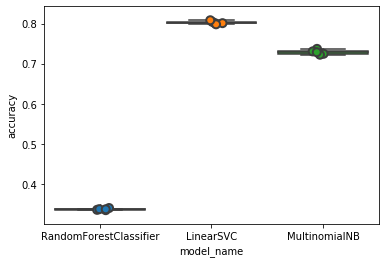

In [42]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [43]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.802457
MultinomialNB             0.728620
RandomForestClassifier    0.337564
Name: accuracy, dtype: float64